In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
dataset_name = 'mosad'
output_dir = f'./../../processed/{dataset_name}/'
os.makedirs(output_dir, exist_ok=True)
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')

In [4]:
def load_mosad_dataset():
    cp_filename = "./datasets/change_points.txt"
    cp_file = []

    with open(cp_filename, 'r') as file:
        for line in file.readlines(): cp_file.append(line.split(","))
        
    activity_filename = "./datasets/activities.txt"
    activities = dict()

    with open(activity_filename, 'r') as file:
        for line in file.readlines():
            line = line.split(",")
            routine, motions = line[0], line[1:]
            activities[routine] = [motion.replace("\n", "") for motion in motions]

    ts_filename = "./datasets/data.npz"
    T = np.load(file=ts_filename)

    df = []

    for row in cp_file:
        (ts_name, sample_rate), change_points = row[:2], row[2:]
        routine, subject, sensor = ts_name.split("_")
        ts = T[ts_name]

        df.append((ts_name, int(routine[-1]), int(subject[-1]), sensor, int(sample_rate), np.array([int(_) for _ in change_points]), np.array(activities[routine[-1]]), ts))

    return pd.DataFrame.from_records(df, columns=["dataset", "routine", "subject", "sensor", "sample_rate", "change_points", "activities", "time_series"])

In [5]:
df_mosad = load_mosad_dataset()
df_mosad

,dataset,routine,subject,sensor,sample_rate,change_points,activities,time_series
0,Routine1_Subject1_X-Acc,1,1,X-Acc,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[-0.1986, -0.454326, -0.5473, -0.496056, -0.48..."
1,Routine1_Subject1_X-Gyro,1,1,X-Gyro,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[0.0174, 0.0358, 0.0431, 0.0358, 0.0168, 0.008..."
2,Routine1_Subject1_X-Mag,1,1,X-Mag,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[-31.02, -30.84, -30.65, -30.58, -31.52, -30.7..."
3,Routine1_Subject1_Y-Acc,1,1,Y-Acc,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[-0.0161, -0.100877, -0.1434, -0.13972, -0.081..."
4,Routine1_Subject1_Y-Gyro,1,1,Y-Gyro,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[-0.0525, -0.0568, -0.0482, -0.0012, 0.0153, 0..."
...,...,...,...,...,...,...,...,...
121,Routine3_Subject5_Y-Gyro,3,5,Y-Gyro,50,"[6056, 9160, 15209, 16735, 17785]","[slow walk, run, walk, rope jump, squat, jumpi...","[0.0923, 0.137903, 0.118283, 0.0465, -0.035871..."
122,Routine3_Subject5_Y-Mag,3,5,Y-Mag,50,"[6056, 9160, 15209, 16735, 17785]","[slow walk, run, walk, rope jump, squat, jumpi...","[187.01, 187.93, 187.78, 185.81, 185.66, 186.5..."
123,Routine3_Subject5_Z-Acc,3,5,Z-Acc,50,"[6056, 9160, 15209, 16735, 17785]","[slow walk, run, walk, rope jump, squat, jumpi...","[0.0949, 0.4038, 0.4038, 0.4038, 0.418, 0.418,..."
124,Routine3_Subject5_Z-Gyro,3,5,Z-Gyro,50,"[6056, 9160, 15209, 16735, 17785]","[slow walk, run, walk, rope jump, squat, jumpi...","[-0.1484, -0.128387, -0.098542, -0.0622, -0.04..."


In [6]:
grouped = df_mosad.groupby(['routine', 'subject'])

In [7]:
dfs = []
for name, group in grouped:
    experiment_data = {}
    for i, row in group.iterrows():
        sensor_name = row['sensor']
        experiment_data[sensor_name] = row['time_series']

    activities = row['activities']
    change_points = row['change_points']
    processed_activities = ['' for _ in range(len(row['time_series']))]
        
    processed_activities[0] = activities[0]
    for i, j in zip(change_points, activities[1:]):
        processed_activities[i] = j

    df = pd.DataFrame(experiment_data)
    df.insert(0, 'id', f"routine_{row['routine']}_subject_{row['subject']}")
    df.insert(1, 'time_step', range(len(df)))
    df.insert(2, 'routine', row['routine'])
    df.insert(3, 'subject', row['subject'])
    

    df['activities'] = processed_activities
        
    dfs.append(df)
        

In [8]:
data = pd.concat(dfs)

In [9]:
data

,id,time_step,routine,subject,X-Acc,X-Gyro,X-Mag,Y-Acc,Y-Gyro,Y-Mag,Z-Acc,Z-Gyro,Z-Mag,activities
0,routine_1_subject_1,0,1,1,-0.198600,0.0174,-31.020000,-0.016100,-0.0525,-127.260000,0.086500,0.0509,-78.800000,descend stairs
1,routine_1_subject_1,1,1,1,-0.454326,0.0358,-30.840000,-0.100877,-0.0568,-127.410000,0.106412,0.0851,-78.160000,
2,routine_1_subject_1,2,1,1,-0.547300,0.0431,-30.650000,-0.143400,-0.0482,-127.860000,0.010700,0.1157,-78.930000,
3,routine_1_subject_1,3,1,1,-0.496056,0.0358,-30.580000,-0.139720,-0.0012,-127.230000,-0.143706,0.1291,-79.720000,
4,routine_1_subject_1,4,1,1,-0.480500,0.0168,-31.520000,-0.081900,0.0153,-127.270000,-0.200700,0.1193,-79.140000,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19396,routine_3_subject_5,19396,3,5,0.443500,-0.0503,7.777608,-0.820100,-0.1455,-25.363487,-0.197300,-0.1785,-25.712826,
19397,routine_3_subject_5,19397,3,5,0.547000,-0.0198,7.566146,0.739000,-0.1290,-25.310689,-0.197000,-0.2280,-25.725660,
19398,routine_3_subject_5,19398,3,5,0.547000,0.0303,7.077993,0.739000,-0.1595,-25.325167,-0.197000,-0.2170,-25.778003,
19399,routine_3_subject_5,19399,3,5,0.547000,0.0658,7.042792,0.739000,-0.2194,-25.728202,-0.197000,-0.1742,-24.757846,


<Axes: xlabel='subject'>

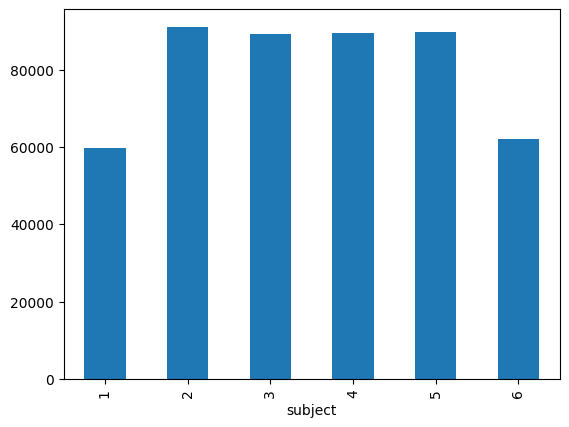

In [17]:
data['subject'].value_counts().sort_index().plot(kind='bar')